# This is starter file for more customizable ViT with pytorch raw

I have not futzed with this much yet

In [ ]:
# array data manipulation and plotting
import os
import glob
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from transformers import ViTConfig, ViTForImageClassification

# machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, \
    accuracy_score, \
    f1_score, \
    auc, \
    recall_score, \
    precision_score, \
    precision_recall_curve, \
    roc_curve
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# uncomment if not running with papermill
# this does not have to be equal to total number of augmentations
# used during training
num_augmentations = 2

In [ ]:
batch_size = 2**9 # for the scaling
scaler = joblib.load('standard_scaler.joblib')

# --- LOAD THE X AND Y DATA ---

main_path = 'data'
train_folders = [f'{main_path}/val',
                 # f'{main_path}/rain-sounds', f'{main_path}/colored-noise'
]
test_folders = [f'{main_path}/test']

# ---------- TRAINING DATA ----------

num_augmentations = int(num_augmentations)

X_list = []
Y_list = []

for folder in train_folders:
    # find files like X_1000.npy, X_2000.npy, etc.
    X_files = sorted(glob.glob(os.path.join(folder, "X_original_*.npy")))
    Y_files = sorted(glob.glob(os.path.join(folder, "Y_original_*.npy")))

    for xf in X_files:
        X_list.append(np.load(xf))
    for yf in Y_files:
        Y_list.append(np.load(yf))

for n in range(1, num_augmentations):

    for folder in train_folders:
        # find files like X_1000.npy, X_2000.npy, etc.
        X_files = sorted(glob.glob(os.path.join(folder, f"X_augmented_run{n}_*.npy")))
        Y_files = sorted(glob.glob(os.path.join(folder, f"Y_augmented_run{n}_*.npy")))

        for xf in X_files:
            X_list.append(np.load(xf))
        for yf in Y_files:
            Y_list.append(np.load(yf))

# Stack into arrays
X_train = np.vstack(X_list)
Y_train = np.concatenate(Y_list)

# Cleanup
del X_list
del Y_list

# ---------- TESTING DATA ----------

X_list = []
Y_list = []

for folder in test_folders:
    # find files like X_1000.npy, X_2000.npy, etc.
    X_files = sorted(glob.glob(os.path.join(folder, "X_original_*.npy")))
    Y_files = sorted(glob.glob(os.path.join(folder, "Y_original_*.npy")))
    for yf in Y_files:
        Y_list.append(np.load(yf))
    for xf in X_files:
        X_list.append(np.load(xf))

for n in range(1, num_augmentations):

    for folder in test_folders:
        # find files like X_1000.npy, X_2000.npy, etc.
        X_files = sorted(glob.glob(os.path.join(folder, f"X_augmented_run{n}_*.npy")))
        Y_files = sorted(glob.glob(os.path.join(folder, f"Y_augmented_run{n}_*.npy")))

        for xf in X_files:
            X_list.append(np.load(xf))
        for yf in Y_files:
            Y_list.append(np.load(yf))

# Stack into arrays
X_test = np.vstack(X_list)
Y_test = np.concatenate(Y_list)

# Cleanup
del X_list
del Y_list

In [ ]:
# --- SCALE THE DATA ---

# Wrap it in a Dataset
class NumpyDataset(Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]  # returns NumPy arrays

# training data

BA, FR, TI = X_train.shape

X_train_2d = X_train.reshape(BA, FR * TI)
del X_train

dataset = NumpyDataset(X_train_2d)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
X_train_scaled = []
itr = 0
for batch in loader:
    itr += 1
    if itr % 10 == 0:
        print(f'Processed {itr} batches')
    # Convert batch to numpy array for StandardScaler
    batch_scaled = scaler.transform(batch)
    X_train_scaled.append(batch_scaled)

X_train_scaled = np.vstack(X_train_scaled)
X_train_scaled_2d = X_train_scaled.reshape(BA, FR, TI)
del X_train_scaled
X_train = X_train_scaled_2d
del X_train_scaled_2d

# testing data

BA, FR, TI = X_test.shape

X_test_2d = X_test.reshape(BA, FR * TI)
del X_test

dataset = NumpyDataset(X_test_2d)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
X_test_scaled = []
itr = 0
for batch in loader:
    itr += 1
    if itr % 10 == 0:
        print(f'Processed {itr} batches')
    # Convert batch to numpy array for StandardScaler
    batch_scaled = scaler.transform(batch)
    X_test_scaled.append(batch_scaled)

X_test_scaled = np.vstack(X_test_scaled)
X_test_scaled_2d = X_test_scaled.reshape(BA, FR, TI)
del X_test_scaled
X_test = X_test_scaled_2d
del X_test_scaled_2d


print()
print('Transformed with the standard scaler')
print()

In [ ]:
patch_h = 16
patch_w = 16
batch_size = 2**4 # for training

# --- CHANGE UNUSUAL DIMENSION ---
X_height = X_train.shape[1]
X_width = X_train.shape[2]
X_train = X_train[:,:X_height//patch_h*patch_h,:X_width//patch_w*patch_w]
X_train = X_train[:,np.newaxis,:,:]

X_height = X_test.shape[1]
X_width = X_test.shape[2]
X_test = X_test[:,:X_height//patch_h*patch_h,:X_width//patch_w*patch_w]
X_test = X_test[:,np.newaxis,:,:]

# --- MAKE TENSORS ---
num_classes = len(np.unique(Y_train))
Y_train = torch.tensor(Y_train, dtype=torch.long)
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)

# --- DATA LOADER ---
train_data = TensorDataset(X_train, Y_train)
test_data = TensorDataset(X_test, Y_test)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# del X_train, Y_train, X_test, Y_test

In [ ]:
embed_dim = 192
depth = 12
num_heads = 6
dropout = 0.2

In [17]:
class AcousticViT(nn.Module):
    def __init__(self, num_classes, patch_size, embed_dim, num_heads, depth, dropout):
        super(AcousticViT, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth

        # Patch embedding
        self.patch_embedding = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, embed_dim))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, 
                                                   nhead=num_heads, 
                                                   dim_feedforward=embed_dim, 
                                                   dropout=dropout, 
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Classification head
        self.classification_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Patch embedding
        x = self.patch_embedding(x)  # (B, embed_dim, num_patches)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.permute(0, 2, 1)  # (B, num_patches, embed_dim)

        # Positional encoding
        x += self.positional_encoding

        # Transformer encoder
        x = self.transformer_encoder(x)

        # Classification head
        x = x.mean(dim=1)  # (B, embed_dim)
        x = self.classification_head(x)
        return x

In [18]:
model = AcousticViT(
    num_classes=num_classes,
    patch_size=(patch_h,patch_w),
    embed_dim=embed_dim,
    num_heads=num_heads,
    depth=depth,
    dropout=dropout,
)

In [19]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [21]:
# Training loop

model.to(device)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Pass to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1/10, Loss: 2.0880
Epoch 2/10, Loss: 1.7431
Epoch 3/10, Loss: 1.4846
Epoch 4/10, Loss: 1.3081
Epoch 5/10, Loss: 1.1744
Epoch 6/10, Loss: 1.0681
Epoch 7/10, Loss: 0.9827
Epoch 8/10, Loss: 0.8995
Epoch 9/10, Loss: 0.8374
Epoch 10/10, Loss: 0.7675


In [32]:
model.to(device)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = np.argmax(outputs.cpu().numpy(), axis=1)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Training Accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(all_labels, all_preds))

Training Accuracy: 0.7908
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      3168
           1       0.77      0.71      0.74      2994
           2       0.82      0.90      0.86      4263
           3       0.81      0.75      0.78      2955
           4       0.90      0.67      0.77      1908
           5       0.70      0.80      0.74      2322
           6       0.75      0.73      0.74      2178
           7       0.72      0.84      0.78      2886
           8       0.79      0.76      0.77      1734
           9       0.89      0.78      0.83      1749

    accuracy                           0.79     26157
   macro avg       0.80      0.78      0.78     26157
weighted avg       0.80      0.79      0.79     26157



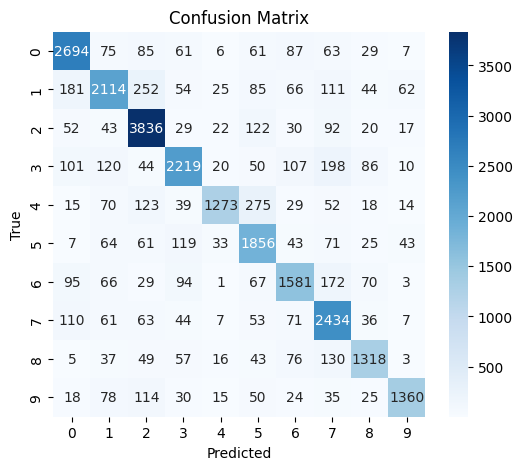

In [33]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', )
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:
model.to(device)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = np.argmax(outputs.cpu().numpy(), axis=1)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Training Accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(all_labels, all_preds))

Training Accuracy: 0.5100
              precision    recall  f1-score   support

           0       0.47      0.59      0.52       381
           1       0.36      0.32      0.34       420
           2       0.55      0.73      0.63       483
           3       0.61      0.61      0.61       396
           4       0.61      0.23      0.33       435
           5       0.51      0.67      0.58       198
           6       0.37      0.23      0.29       324
           7       0.55      0.81      0.66       402
           8       0.54      0.49      0.52       237
           9       0.46      0.38      0.42       273

    accuracy                           0.51      3549
   macro avg       0.50      0.51      0.49      3549
weighted avg       0.51      0.51      0.49      3549



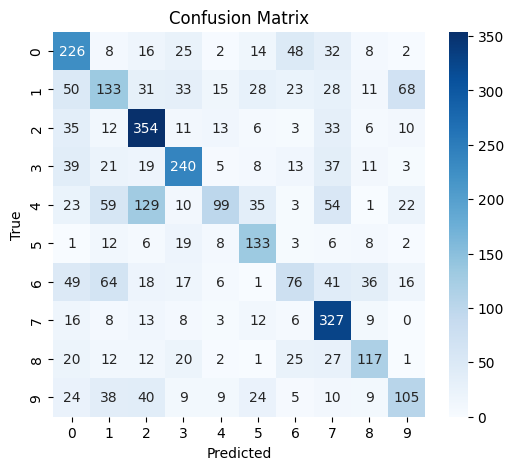

In [35]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', )
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()